# 腦腫瘤分割 - 完整流程

本 notebook 包含從資料探索、資料清理到模型訓練和評估的完整流程。

## 目錄
1. **資料探索與清理** (來自 code.ipynb)
   - 資料集基本資訊
   - 標註分析
   - 問題圖片識別
   - 資料清理

2. **模型訓練流程** (來自 brain_tumor_complete.ipynb)
   - 環境設置
   - 資料增強
   - Dataset 和 DataLoader
   - U-Net 模型
   - 訓練與驗證
   - 測試與視覺化


---
# Part 1: 資料探索與清理
---

在訓練模型之前,我們需要先了解和清理資料集。


## Brain Tumor Image

### 01 Data input

In [1]:
import json
from collections import Counter

path = r".\train\_annotations.coco.json"
with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

print("images:", len(data.get("images", [])))
print("annotations:", len(data.get("annotations", [])))
print("categories:", len(data.get("categories", [])))
print("category names:", [c.get("name") for c in data.get("categories", [])])

# example: annotation counts per category id
cat_counts = Counter(a["category_id"] for a in data.get("annotations", []))
print("annotations per category id:", dict(cat_counts))

images: 1502
annotations: 1502
categories: 3
category names: ['Tumor', '0', '1']
annotations per category id: {1: 771, 2: 731}


成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。
--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
找到 1502 張圖片的紀錄。
找到 1501 張有標註的圖片。

--- 沒有標註的圖片 (Image IDs) ---
共 1 張:
[1380]

--- 有多個標註的圖片 (Image IDs) ---
共 1 張:
[1005]

--- 隨機顯示 3 張範例圖片 ---
將顯示 Image IDs: [678, 1093, 377]

已儲存範例圖片至 annotation_analysis_samples_bw_mask.png
--- 程式碼執行完畢 ---


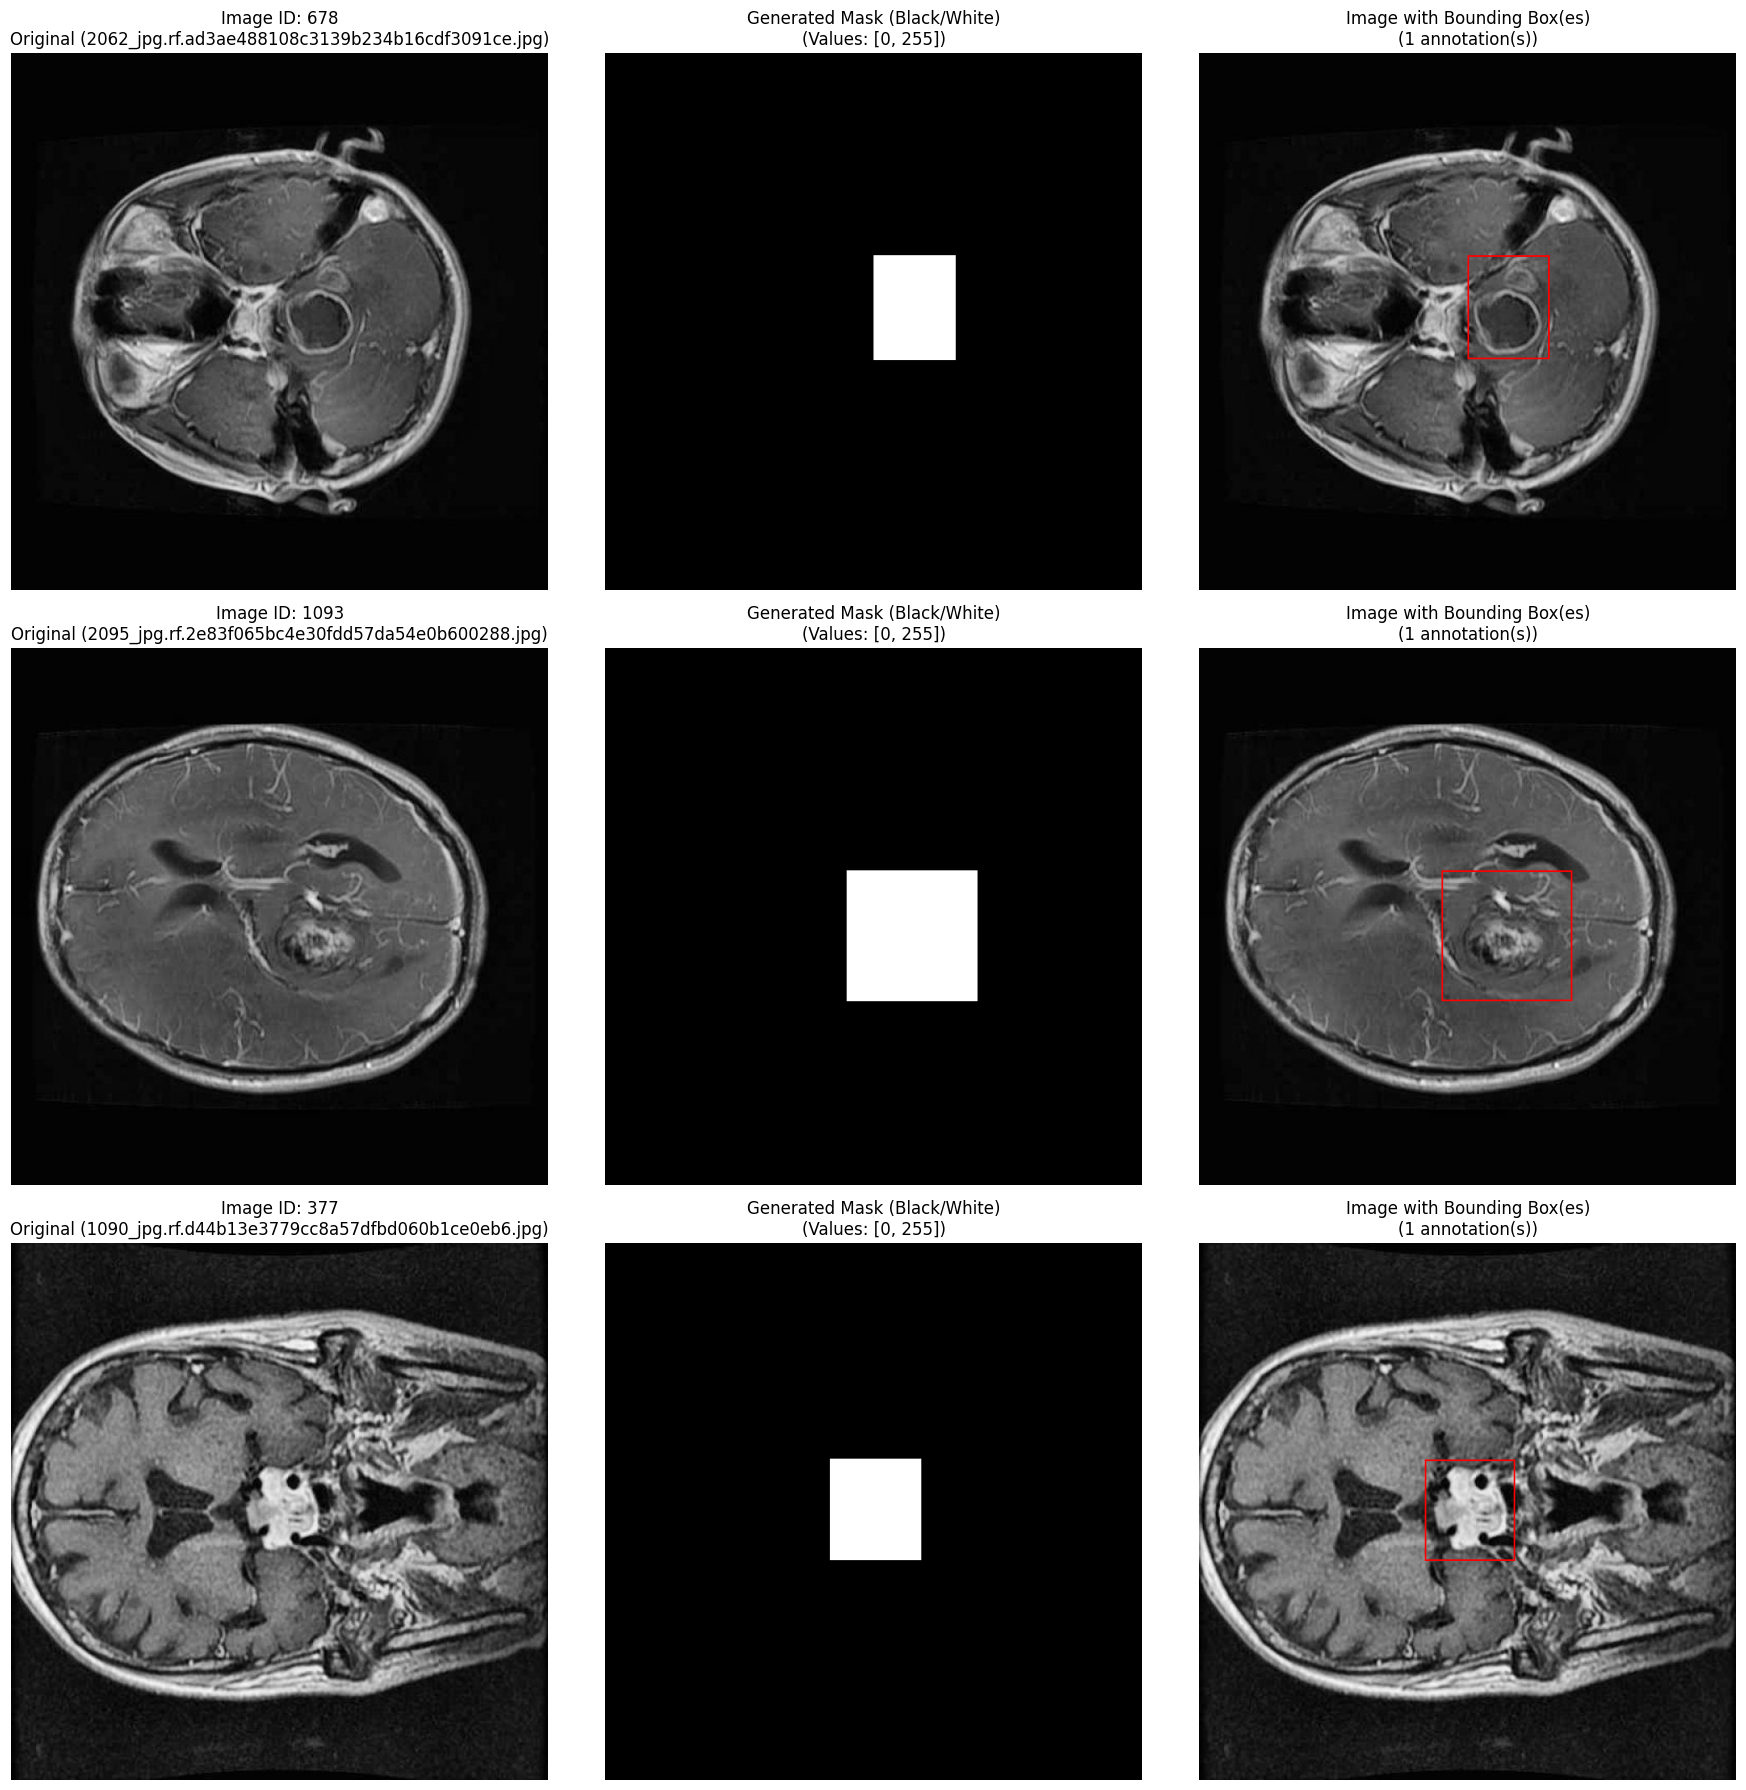

In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫，用於圖片處理
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"
num_samples_to_show = 3

print(f"--- 程式碼開始 ---")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        print("請上傳此檔案後再試一次。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")
        
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 處理圖像和標註 ---
    all_image_ids = set()
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            all_image_ids.add(img['id'])
            image_id_to_file[img['id']] = img['file_name']
    print(f"找到 {len(all_image_ids)} 張圖片的紀錄。")

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)
    print(f"找到 {len(image_id_to_annotations)} 張有標註的圖片。")

    # --- 3. 找出沒有標註的圖片 ---
    annotated_image_ids = set(image_id_to_annotations.keys())
    unannotated_image_ids = all_image_ids - annotated_image_ids
    
    print("\n--- 沒有標註的圖片 (Image IDs) ---")
    if unannotated_image_ids:
        print(f"共 {len(unannotated_image_ids)} 張:")
        print(list(unannotated_image_ids))
    else:
        print("所有圖片都有標註。")

    # --- 4. 找出有多個標註的圖片 ---
    multiple_annotated_image_ids = {img_id for img_id, annos in image_id_to_annotations.items() if len(annos) > 1}
            
    print("\n--- 有多個標註的圖片 (Image IDs) ---")
    if multiple_annotated_image_ids:
        print(f"共 {len(multiple_annotated_image_ids)} 張:")
        print(list(multiple_annotated_image_ids)[:50])
        if len(multiple_annotated_image_ids) > 50:
            print(f"... (還有 {len(multiple_annotated_image_ids) - 50} 個)")
    else:
        print("沒有圖片有多於一個標註。")

    # --- 5. 隨機挑選 {num_samples_to_show} 張有標註的圖片顯示 ---
    print(f"\n--- 隨機顯示 {num_samples_to_show} 張範例圖片 ---")
    
    annotated_image_id_list = list(annotated_image_ids)
    
    if not annotated_image_id_list:
        print("沒有可顯示的有標註圖片。")
    else:
        num_to_sample = min(num_samples_to_show, len(annotated_image_id_list))
        if num_to_sample < num_samples_to_show:
            print(f"警告：有標註的圖片少於 {num_samples_to_show} 張，僅顯示 {num_to_sample} 張。")
            
        sample_image_ids = random.sample(annotated_image_id_list, num_to_sample)
        print(f"將顯示 Image IDs: {sample_image_ids}")

        fig, axes = plt.subplots(num_to_sample, 3, figsize=(18, 6 * num_to_sample))
        if num_to_sample == 1:
            axes = np.array([axes])

        for i, sample_image_id in enumerate(sample_image_ids):
            try:
                file_name = image_id_to_file[sample_image_id]
                image_path = os.path.join(image_base_dir, file_name)
                
                if not os.path.exists(image_path):
                    print(f"錯誤：找不到圖片檔案 {image_path}")
                    axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                    axes[i, 0].axis('off')
                    axes[i, 1].axis('off')
                    axes[i, 2].axis('off')
                    continue

                # 使用 PIL 載入圖片
                image = Image.open(image_path).convert("RGB")
                
                # 準備 Mask (使用 PIL)
                # 'L' mode for 8-bit grayscale mask (0 = 黑色)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)
                
                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)
                
                mask_values = {0} # 0 代表背景 (黑色)
                
                annotations = image_id_to_annotations[sample_image_id]
                
                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox'] # [x, y, w, h]
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            # *** 修改：將 fill 改為 255 (白色) ***
                            mask_draw.polygon(poly, fill=255)
                        
                        if segmentation: # 如果真的有畫多邊形
                            # *** 將 mask value 記錄為 255 ***
                            mask_values.add(255)

                # --- 顯示 ---
                
                # 欄 1: 原始圖片
                ax = axes[i, 0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {sample_image_id}\nOriginal ({file_name})")
                ax.axis('off')
                
                # 欄 2: 標註 Mask
                ax = axes[i, 1]
                # *** 使用 'gray' colormap 顯示黑白 ***
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255) 
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')
                
                # 欄 3: Image with Bounding Box
                ax = axes[i, 2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

            except FileNotFoundError:
                print(f"錯誤：在處理 ID {sample_image_id} 時找不到圖片檔案 {image_path}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
            except Exception as e:
                print(f"處理 Image ID {sample_image_id} 時發生嚴重錯誤: {e}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nError: {e}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
        
        plt.tight_layout()
        # 儲存為新檔名
        plt.savefig("annotation_analysis_samples_bw_mask.png")
        print("\n已儲存範例圖片至 annotation_analysis_samples_bw_mask.png")

except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
    print("請上傳此檔案以及範例圖片，然後重新執行。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("--- 程式碼執行完畢 ---")

成功匯入 PIL (Pillow)。
--- 程式碼開始 ---
將顯示 Image IDs: [1380, 1005]
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。

--- 正在處理 Image ID: 1380 ---
Image ID 1380 (2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg) 沒有標註。
已儲存圖片至 image_1380_original.png

--- 正在處理 Image ID: 1005 ---
Image ID 1005 (176_jpg.rf.23ef40c30986ba54b865d55a934bfa72.jpg) 有 2 個標註。
已儲存圖片至 image_1005_annotated.png

--- 程式碼執行完畢 ---


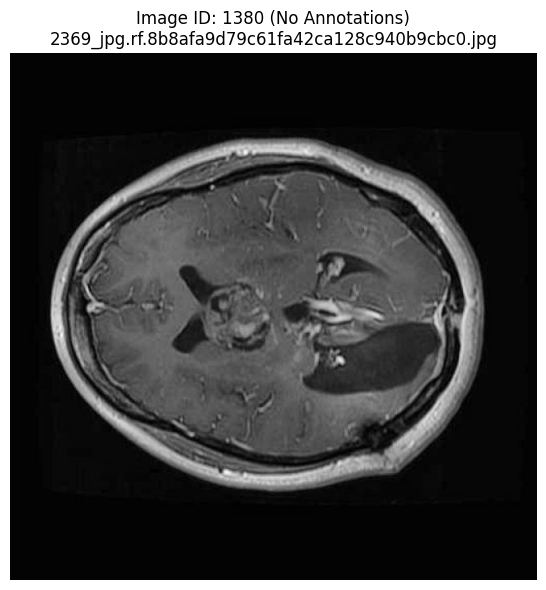

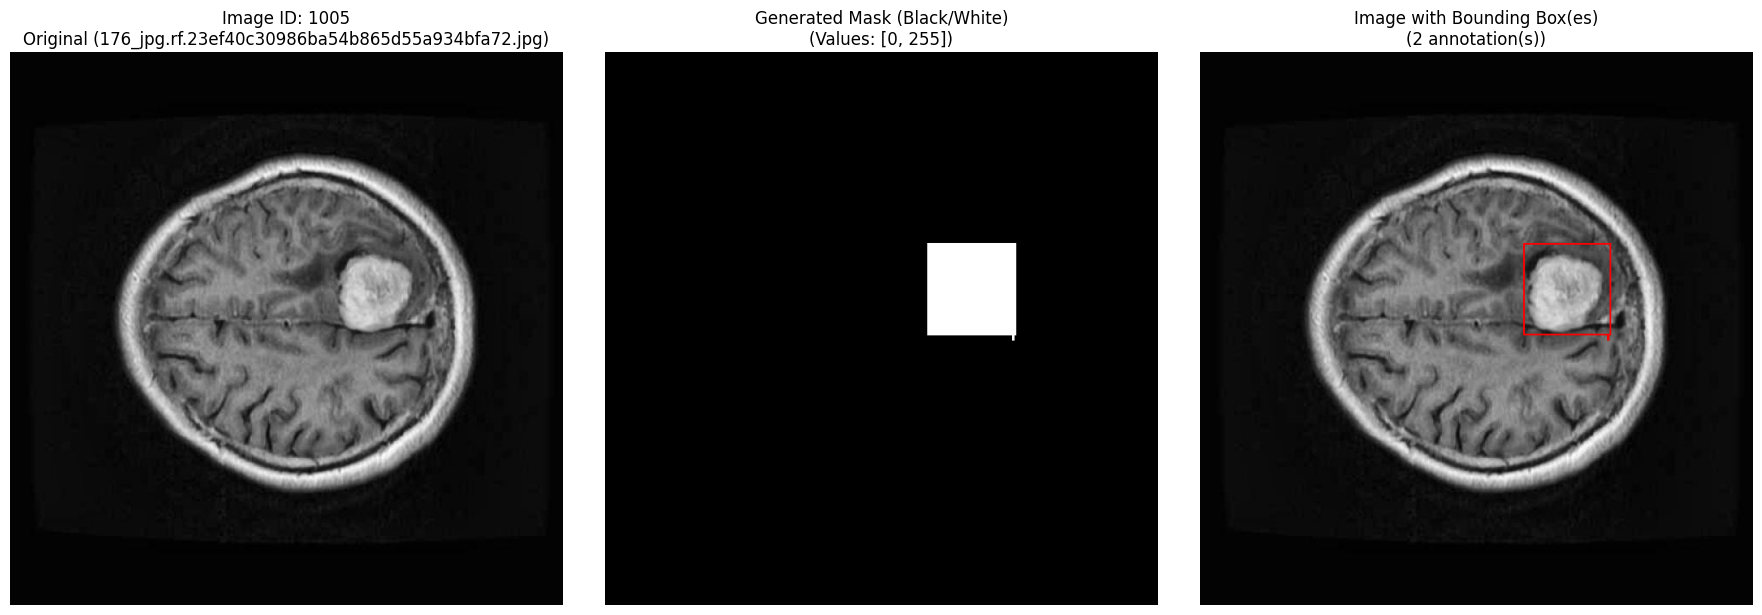

In [3]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json" # 從上次成功執行的路徑讀取
image_base_dir = "./train" # 從上次成功執行的路徑讀取
ids_to_display = [1380, 1005] # 指定要顯示的 Image IDs

print(f"--- 程式碼開始 ---")
print(f"將顯示 Image IDs: {ids_to_display}")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 建立必要映射 ---
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            image_id_to_file[img['id']] = img['file_name']

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)

    # --- 3. 顯示指定的圖片 ---
    for target_id in ids_to_display:
        print(f"\n--- 正在處理 Image ID: {target_id} ---")

        if target_id not in image_id_to_file:
            print(f"錯誤：在 JSON 的 'images' 中找不到 Image ID {target_id} 的紀錄。")
            continue

        file_name = image_id_to_file[target_id]
        image_path = os.path.join(image_base_dir, file_name)

        if not os.path.exists(image_path):
            print(f"錯誤：找不到圖片檔案 {image_path}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nFile Not Found: {file_name}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")
            continue

        try:
            # 使用 PIL 載入圖片
            image = Image.open(image_path).convert("RGB")
            annotations = image_id_to_annotations.get(target_id, []) # 使用 .get() 避免 ID 不存在時出錯

            if not annotations:
                # 如果沒有標註 (例如 ID 1380)
                print(f"Image ID {target_id} ({file_name}) 沒有標註。")
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id} (No Annotations)\n{file_name}")
                ax.axis('off')
                plt.tight_layout()
                plt.savefig(f"image_{target_id}_original.png")
                print(f"已儲存圖片至 image_{target_id}_original.png")
            else:
                # 如果有標註 (例如 ID 1005)
                print(f"Image ID {target_id} ({file_name}) 有 {len(annotations)} 個標註。")
                fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 顯示原圖、遮罩、邊界框

                # 準備 Mask (使用 PIL)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)

                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)

                mask_values = {0}

                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox']
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask (黑白)
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            mask_draw.polygon(poly, fill=255)
                        if segmentation:
                            mask_values.add(255)

                # 顯示 - 欄 1: 原始圖片
                ax = axes[0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id}\nOriginal ({file_name})")
                ax.axis('off')

                # 顯示 - 欄 2: 標註 Mask (黑白)
                ax = axes[1]
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255)
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')

                # 顯示 - 欄 3: Image with Bounding Box
                ax = axes[2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

                plt.tight_layout()
                plt.savefig(f"image_{target_id}_annotated.png")
                print(f"已儲存圖片至 image_{target_id}_annotated.png")

        except Exception as e:
            print(f"處理 Image ID {target_id} 時發生錯誤: {e}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nError Processing: {e}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 沿用之前的設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"

print(f"--- 程式碼開始 ---")

try:
    # --- 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 記錄原始數量 ---
    original_image_count = len(data.get('images', []))
    original_annotation_count = len(data.get('annotations', []))
    print(f"原始圖片數量: {original_image_count}")
    print(f"原始標註數量: {original_annotation_count}")

    # --- 定義要移除的 ID 列表 ---
    # 這次包含上次的 1380 和這次的 1005
    image_ids_to_remove = {1380, 1005}
    print(f"\n正在移除 Image IDs {list(image_ids_to_remove)} 的紀錄...")

    # --- 移除指定的 Image IDs ---
    removed_image_count_total = 0
    removed_annotation_count_total = 0

    # 篩選 images 列表
    if 'images' in data:
        original_images = data['images']
        # 保留 ID 不在移除列表中的圖片
        data['images'] = [img for img in original_images if img.get('id') not in image_ids_to_remove]
        removed_image_count_total = original_image_count - len(data['images'])
        print(f"- 已從 'images' 移除 {removed_image_count_total} 筆紀錄。")

    # 篩選 annotations 列表
    if 'annotations' in data:
        original_annotations = data['annotations']
         # 保留 image_id 不在移除列表中的標註
        data['annotations'] = [ann for ann in original_annotations if ann.get('image_id') not in image_ids_to_remove]
        removed_annotation_count_total = original_annotation_count - len(data['annotations'])
        print(f"- 已從 'annotations' 移除 {removed_annotation_count_total} 筆紀錄。")

    # --- 記錄處理後數量 ---
    final_image_count = len(data.get('images', []))
    final_annotation_count = len(data.get('annotations', []))
    print(f"\n處理後圖片數量: {final_image_count}")
    print(f"處理後標註數量: {final_annotation_count}")

    # --- 重要提示 ---
    print("\n注意：上述移除操作僅在目前的程式記憶體中生效。")
    print("永久保存這個修改，將 'data' 變數寫入一個新的 JSON 檔案(./train/_annotations.coco.cleaned.json)。")
    # 例如:
    cleaned_json_path = "./train/_annotations.coco.cleaned.json"
    with open(cleaned_json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"已將清理後的資料儲存至 {cleaned_json_path}")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
原始圖片數量: 1502
原始標註數量: 1502

正在移除 Image IDs [1380, 1005] 的紀錄...
- 已從 'images' 移除 2 筆紀錄。
- 已從 'annotations' 移除 2 筆紀錄。

處理後圖片數量: 1500
處理後標註數量: 1500

注意：上述移除操作僅在目前的程式記憶體中生效。
永久保存這個修改，將 'data' 變數寫入一個新的 JSON 檔案(./train/_annotations.coco.cleaned.json)。
已將清理後的資料儲存至 ./train/_annotations.coco.cleaned.json

--- 程式碼執行完畢 ---


### 資料清理 - 驗證集和測試集

將訓練集的清理操作應用到驗證集和測試集。


In [5]:
# ============================================================
# 資料清理 - 驗證集和測試集
# ============================================================
# 此 cell 對驗證集和測試集套用與訓練集相同的資料清理操作
# 移除有問題的圖片 ID: 1380 (無標註) 和 1005 (多重標註)

import json
import os

def clean_dataset(json_path, image_ids_to_remove, output_path):
    """
    清理資料集,移除指定的 image IDs
    
    參數:
        json_path: 原始 JSON 檔案路徑
        image_ids_to_remove: 要移除的 image ID 集合
        output_path: 輸出的清理後 JSON 檔案路徑
    
    返回:
        bool: 成功返回 True,失敗返回 False
    """
    print(f"\n{'='*60}")
    print(f"處理: {json_path}")
    print(f"{'='*60}")
    
    try:
        # 讀取 JSON 檔案
        if not os.path.exists(json_path):
            print(f"警告: 找不到檔案 '{json_path}',跳過處理。")
            return False
        
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # 記錄原始數量
        original_image_count = len(data.get('images', []))
        original_annotation_count = len(data.get('annotations', []))
        print(f"原始: {original_image_count} 張圖片, {original_annotation_count} 個標註")
        
        # 過濾 images 列表
        if 'images' in data:
            data['images'] = [img for img in data['images'] 
                            if img.get('id') not in image_ids_to_remove]
            removed_images = original_image_count - len(data['images'])
        
        # 過濾 annotations 列表
        if 'annotations' in data:
            data['annotations'] = [ann for ann in data['annotations'] 
                                 if ann.get('image_id') not in image_ids_to_remove]
            removed_annotations = original_annotation_count - len(data['annotations'])
        
        # 記錄處理後數量
        final_image_count = len(data.get('images', []))
        final_annotation_count = len(data.get('annotations', []))
        
        print(f"移除: {removed_images} 張圖片, {removed_annotations} 個標註")
        print(f"剩餘: {final_image_count} 張圖片, {final_annotation_count} 個標註")
        
        # 儲存清理後的資料
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"✓ 已儲存至: {output_path}")
        
        return True
        
    except Exception as e:
        print(f"錯誤: {e}")
        return False

# ===== 主程式 =====
print("="*60)
print("開始清理驗證集和測試集")
print("="*60)

# 定義要移除的 ID (與訓練集相同)
image_ids_to_remove = {1380, 1005}
print(f"\n要移除的 Image IDs: {list(image_ids_to_remove)}")

# 處理驗證集
valid_success = clean_dataset(
    json_path="./valid/_annotations.coco.json",
    image_ids_to_remove=image_ids_to_remove,
    output_path="./valid/_annotations.coco.cleaned.json"
)

# 處理測試集
test_success = clean_dataset(
    json_path="./test/_annotations.coco.json",
    image_ids_to_remove=image_ids_to_remove,
    output_path="./test/_annotations.coco.cleaned.json"
)

# 總結
print("\n" + "="*60)
print("清理完成!")
print("="*60)
print(f"驗證集: {'✓ 成功' if valid_success else '✗ 失敗'}")
print(f"測試集: {'✓ 成功' if test_success else '✗ 失敗'}")
print("\n注意:")
print("- 清理後的檔案已儲存為 _annotations.coco.cleaned.json")
print("- 如需使用清理後的資料,請載入這些新檔案")
print("="*60)


開始清理驗證集和測試集

要移除的 Image IDs: [1380, 1005]

處理: ./valid/_annotations.coco.json
原始: 429 張圖片, 429 個標註
移除: 0 張圖片, 0 個標註
剩餘: 429 張圖片, 429 個標註
✓ 已儲存至: ./valid/_annotations.coco.cleaned.json

處理: ./test/_annotations.coco.json
原始: 215 張圖片, 215 個標註
移除: 0 張圖片, 0 個標註
剩餘: 215 張圖片, 215 個標註
✓ 已儲存至: ./test/_annotations.coco.cleaned.json

清理完成!
驗證集: ✓ 成功
測試集: ✓ 成功

注意:
- 清理後的檔案已儲存為 _annotations.coco.cleaned.json
- 如需使用清理後的資料,請載入這些新檔案


---
# Part 2: 模型訓練與評估
---

使用清理後的資料集進行 U-Net 模型的訓練和評估。


# 腦腫瘤影像分割專案

這是一個完整的深度學習專案，使用 U-Net 架構進行腦腫瘤 MRI 影像分割。

## 專案特色

- ✅ 完整的 U-Net 實作
- ✅ 資料增強（Albumentations）
- ✅ 組合損失函數（Dice + BCE）
- ✅ 完整的訓練與評估流程
- ✅ 視覺化功能
- ✅ Windows / GTX 960 優化設定

## 硬體需求

- **建議**: NVIDIA GPU (CUDA 支援)
- **本專案優化**: GTX 960 4GB
- **最低**: CPU（會很慢）

---

## 1. 環境設定 & 套件導入

首先設定環境變數解決 Windows 系統的相容性問題，並導入所有必要的套件。

In [6]:
# Windows OpenMP conflicts fix
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision Training
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# Segmentation Models PyTorch (SMP Library)
import segmentation_models_pytorch as smp

# Data processing
import numpy as np
import cv2
from PIL import Image
import json
from pathlib import Path
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import gc  # Memory management

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

print('[OK] Import successful!')
print('[OK] SMP Library version:', smp.__version__)


[OK] Import successful!
[OK] SMP Library version: 0.5.0


### GPU 檢查

檢查 CUDA 是否可用，以及 GPU 資訊。

In [7]:
# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用裝置: {device}")

if torch.cuda.is_available():
    print(f"GPU 名稱: {torch.cuda.get_device_name(0)}")
    print(f"GPU 數量: {torch.cuda.device_count()}")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"顯存總量: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ CUDA 不可用，將使用 CPU（訓練會很慢）")

使用裝置: cuda
GPU 名稱: NVIDIA GeForce GTX 960
GPU 數量: 1
CUDA 版本: 12.1
顯存總量: 4.00 GB


## 2. 資料增強 & 預處理

使用 Albumentations 庫進行資料增強。訓練集使用多種增強技術，驗證集只進行基本的調整大小和正規化。

In [8]:
class TrainTransform:
    """訓練集的資料增強"""
    def __init__(self, image_size=256):  # 改為 256
        self.transform = A.Compose([
            A.Resize(image_size, image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(p=0.2),
            A.ElasticTransform(alpha=1, sigma=50, p=0.2),  # 移除 alpha_affine
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ], is_check_shapes=False)
    
    def __call__(self, image, mask):
        transformed = self.transform(image=image, mask=mask)
        return transformed['image'], transformed['mask']


class ValidTransform:
    """驗證集/測試集的資料轉換（不增強）"""
    def __init__(self, image_size=256):  # 改為 256
        self.transform = A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ], is_check_shapes=False)
    
    def __call__(self, image, mask):
        transformed = self.transform(image=image, mask=mask)
        return transformed['image'], transformed['mask']

print("資料增強類別定義完成！")
print(f"  - Image size: 256x256 (optimized for GTX 960)")

資料增強類別定義完成！
  - Image size: 256x256 (optimized for GTX 960)


## 3. Dataset & DataLoader

自訂 Dataset 類別，從 COCO 格式的標註檔案載入影像和遮罩。

In [9]:
class BrainTumorDataset(Dataset):
    """腦腫瘤影像分割資料集"""
    
    def __init__(self, image_dir, annotation_file, transform=None):
        """
        Args:
            image_dir: 影像資料夾路徑
            annotation_file: COCO格式的annotation JSON檔案
            transform: 資料增強/轉換函數
        """
        self.image_dir = Path(image_dir)
        self.transform = transform
        
        # 載入COCO annotations
        with open(annotation_file, 'r', encoding='utf-8') as f:
            self.coco_data = json.load(f)
        
        # 建立image id到檔名的映射
        self.images = {img['id']: img for img in self.coco_data['images']}
        
        # 建立image id到annotations的映射
        self.image_to_anns = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.image_to_anns[ann['image_id']].append(ann)
        
        # 取得所有image ids
        self.image_ids = list(self.images.keys())
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # 取得image資訊
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        
        # 載入影像
        image_path = self.image_dir / image_info['file_name']
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 建立mask
        height, width = image_info['height'], image_info['width']
        mask = self._create_mask(image_id, height, width)
        
        # 應用轉換
        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            # 如果沒有transform，至少轉成tensor
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        return image, mask
    
    def _create_mask(self, image_id, height, width):
        """從COCO segmentation建立binary mask"""
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # 取得該影像的所有annotations
        annotations = self.image_to_anns[image_id]
        
        for ann in annotations:
            if 'segmentation' in ann:
                # COCO格式的segmentation可能是polygon或RLE
                if isinstance(ann['segmentation'], list):
                    # Polygon格式
                    for seg in ann['segmentation']:
                        poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                        cv2.fillPoly(mask, [poly], 1)
        
        return mask

print("Dataset 類別定義完成！")

Dataset 類別定義完成！


In [10]:
def create_dataloaders(train_dir, valid_dir, test_dir, 
                       train_ann, valid_ann, test_ann,
                       batch_size=8, num_workers=4):
    """建立訓練、驗證、測試的DataLoader"""
    
    # 建立datasets
    train_dataset = BrainTumorDataset(
        train_dir, train_ann, 
        transform=TrainTransform()
    )
    
    valid_dataset = BrainTumorDataset(
        valid_dir, valid_ann,
        transform=ValidTransform()
    )
    
    test_dataset = BrainTumorDataset(
        test_dir, test_ann,
        transform=ValidTransform()
    )
    
    # 建立dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, valid_loader, test_loader

print("DataLoader 工廠函數定義完成！")

DataLoader 工廠函數定義完成！


## 4. U-Net 模型架構

實作經典的 U-Net 架構用於影像分割。

In [11]:
'''
Using Segmentation Models PyTorch (SMP) UNet++
Benefits:
1. ResNet34 pretrained weights (ImageNet)
2. UNet++ architecture (better than standard U-Net)
3. Faster convergence
'''

def create_model(encoder_name='resnet34', encoder_weights='imagenet'):
    '''Create SMP model'''
    model = smp.UnetPlusPlus(
        encoder_name=encoder_name,       # backbone: ResNet34
        encoder_weights=encoder_weights, # pretrained weights
        in_channels=3,                   # RGB input
        classes=1,                       # binary segmentation
    )
    return model

# Create model
model = create_model()
model = model.to(device)

# Show model info
print('[OK] SMP UNet++ model created successfully!')
print(f'  - Encoder: ResNet34 (ImageNet pretrained)')
print(f'  - Architecture: UNet++')
print(f'  - Parameters: {sum(p.numel() for p in model.parameters()):,}')


[OK] SMP UNet++ model created successfully!
  - Encoder: ResNet34 (ImageNet pretrained)
  - Architecture: UNet++
  - Parameters: 26,078,609


### 測試模型創建

In [12]:
# Create SMP UNet++ model
model = create_model()
model = model.to(device)

# Show model info
print('[OK] SMP UNet++ model created successfully!')
print(f'  - Total parameters: {sum(p.numel() for p in model.parameters()):,}')


[OK] SMP UNet++ model created successfully!
  - Total parameters: 26,078,609


## 5. 損失函數

使用組合損失函數：Dice Loss + Binary Cross Entropy

In [13]:
# Combined Loss Functions: BCE + Dice Loss

def dice_loss(pred, target, epsilon=1e-7):
    '''Dice Loss for segmentation'''
    # 確保形狀匹配
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)
    
    # 確保類型正確
    target = target.float()
    
    pred = torch.sigmoid(pred)
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    num = 2. * (pred * target).sum()
    den = pred.sum() + target.sum()
    
    dice = (num + epsilon) / (den + epsilon)
    return 1 - dice


def combined_loss(pred, target):
    '''Combined BCE + Dice Loss'''
    # 確保形狀匹配 - 這是關鍵修復！
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
    
    # 確保類型正確
    target = target.float()
    
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return 0.5 * bce + 0.5 * dice

print('[OK] Loss functions defined!')
print('[INFO] Shape matching added to handle dimension mismatch')

[OK] Loss functions defined!
[INFO] Shape matching added to handle dimension mismatch


## 6. 評估指標

定義 Dice 係數、IoU、Precision、Recall、F1 等評估指標。

In [14]:
def dice_coefficient(pred, target, threshold=0.5):
    """計算Dice係數"""
    # 確保形狀匹配
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)
    
    # 確保類型正確
    target = target.float()
    
    pred = (torch.sigmoid(pred) > threshold).float()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum() + 1e-8)
    
    return dice.item()


def iou_score(pred, target, threshold=0.5):
    """計算IoU (Intersection over Union)"""
    # 確保形狀匹配
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)
    
    # 確保類型正確
    target = target.float()
    
    pred = (torch.sigmoid(pred) > threshold).float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / (union + 1e-8)
    
    return iou.item()


def calculate_metrics(pred, target, threshold=0.5):
    """計算所有評估指標"""
    # 確保形狀匹配
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)
    
    # 確保類型正確
    target = target.float()
    
    pred_binary = (torch.sigmoid(pred) > threshold).float()
    
    # True Positives, False Positives, False Negatives
    tp = (pred_binary * target).sum().item()
    fp = (pred_binary * (1 - target)).sum().item()
    fn = ((1 - pred_binary) * target).sum().item()
    
    # Precision, Recall, F1
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    # Dice & IoU
    dice = dice_coefficient(pred, target, threshold)
    iou = iou_score(pred, target, threshold)
    
    return {
        'dice': dice,
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("評估指標函數定義完成！")

評估指標函數定義完成！


## 7. 訓練 & 驗證函數

包含 Early Stopping、訓練一個 epoch、驗證、完整訓練流程等功能。

In [15]:
class EarlyStopping:
    """Early Stopping來防止過擬合"""
    
    def __init__(self, patience=15, min_delta=0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        elif self.mode == 'min':
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

print("Early Stopping 定義完成！")

Early Stopping 定義完成！


In [16]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """訓練一個epoch"""
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # 反向傳播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 計算指標
        dice = dice_coefficient(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    
    return epoch_loss, epoch_dice


def validate(model, loader, criterion, device):
    """驗證"""
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            dice = dice_coefficient(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    
    return epoch_loss, epoch_dice

print("訓練與驗證函數定義完成！")

訓練與驗證函數定義完成！


In [17]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, 
                scheduler, device, num_epochs=10, patience=15, 
                save_dir='./models'):
    """完整的訓練流程"""
    
    os.makedirs(save_dir, exist_ok=True)
    best_model_path = os.path.join(save_dir, 'best_model.pth')
    
    early_stopping = EarlyStopping(patience=patience, mode='max')
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'valid_loss': [],
        'valid_dice': [],
        'lr': []
    }
    
    best_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 50)
        
        # 訓練
        train_loss, train_dice = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # 驗證
        valid_loss, valid_dice = validate(
            model, valid_loader, criterion, device
        )
        
        # 學習率調整
        scheduler.step(valid_dice)
        current_lr = optimizer.param_groups[0]['lr']
        
        # 記錄
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['valid_loss'].append(valid_loss)
        history['valid_dice'].append(valid_dice)
        history['lr'].append(current_lr)
        
        print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Dice: {valid_dice:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')
        
        # 儲存最佳模型
        if valid_dice > best_dice:
            best_dice = valid_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice,
            }, best_model_path)
            print(f'✓ Saved best model (Dice: {best_dice:.4f})')
        
        # Early Stopping
        early_stopping(valid_dice)
        if early_stopping.early_stop:
            print(f'\nEarly stopping triggered at epoch {epoch + 1}')
            break
    
    return history, best_dice

print("完整訓練流程函數定義完成！")

完整訓練流程函數定義完成！


## 8. 測試 & 視覺化

測試模型並視覺化預測結果。

In [18]:
def test_model(model, test_loader, device, save_dir='./results'):
    """在測試集上評估模型"""
    model.eval()
    
    all_metrics = []
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(tqdm(test_loader, desc='Testing')):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            metrics = calculate_metrics(outputs, masks)
            all_metrics.append(metrics)
    
    # 計算平均指標
    avg_metrics = {
        key: np.mean([m[key] for m in all_metrics])
        for key in all_metrics[0].keys()
    }
    
    return avg_metrics, all_metrics


def visualize_predictions(model, dataset, device, num_samples=5, save_path=None):
    """視覺化預測結果"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            
            # 預測
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            pred_mask = torch.sigmoid(output).cpu().squeeze().numpy()
            
            # 反正規化影像以供顯示
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            mask_np = mask.cpu().squeeze().numpy()
            
            # 畫圖
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
            # Overlay
            axes[i, 3].imshow(image_np)
            axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.5)
            axes[i, 3].set_title('Overlay')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_training_history(history, save_path=None):
    """繪製訓練歷史"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss curve
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['valid_loss'], label='Valid Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Dice curve
    axes[1].plot(history['train_dice'], label='Train Dice')
    axes[1].plot(history['valid_dice'], label='Valid Dice')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Training and Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True)
    
    # Learning rate
    axes[2].plot(history['lr'])
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_yscale('log')
    axes[2].grid(True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("測試與視覺化函數定義完成！")

測試與視覺化函數定義完成！


## 9. 完整訓練範例

⚠️ **重要提醒**: 以下是完整的訓練流程範例。

### GTX 960 / Windows 系統優化設定

- `BATCH_SIZE = 1` - 最保守設定，避免 CUDA timeout
- `NUM_WORKERS = 0` - Windows 相容性
- 已設定 `KMP_DUPLICATE_LIB_OK=TRUE` 解決 OpenMP 衝突

### 訓練時間預估

使用 GTX 960 4GB:
- 每個 epoch: 約 8-12 小時
- 預計總時間: 5-15 天（視 Early Stopping 而定）

建議: 讓訓練在夜間運行，定期檢查進度。

In [19]:
# =============================================================================
# 設定參數
# =============================================================================

# 資料路徑
BASE_DIR = Path('.')
TRAIN_DIR = BASE_DIR / 'train'
VALID_DIR = BASE_DIR / 'valid'
TEST_DIR = BASE_DIR / 'test'

TRAIN_ANN = TRAIN_DIR / '_annotations.coco.cleaned.json'
VALID_ANN = VALID_DIR / '_annotations.coco.cleaned.json'
TEST_ANN = TEST_DIR / '_annotations.coco.cleaned.json'

# 訓練參數（GTX 960 優化設定）
BATCH_SIZE = 4       # 最保守設定，確保穩定訓練
NUM_EPOCHS = 100     # 最多訓練 100 輪
LEARNING_RATE = 1e-4 # 標準學習率
PATIENCE = 15        # Early Stopping 耐心值
NUM_WORKERS = 0      # Windows 系統建議設為 0

print("參數設定完成！")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Num Workers: {NUM_WORKERS}")
print(f"Device: {device}")

參數設定完成！
Batch Size: 4
Num Workers: 0
Device: cuda


In [20]:
# =============================================================================
# 載入資料
# =============================================================================

print('\n' + '='*50)
print('載入資料...')
print('='*50)

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dir=TRAIN_DIR,
    valid_dir=VALID_DIR,
    test_dir=TEST_DIR,
    train_ann=TRAIN_ANN,
    valid_ann=VALID_ANN,
    test_ann=TEST_ANN,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

print(f'訓練集樣本數: {len(train_loader.dataset)}')
print(f'驗證集樣本數: {len(valid_loader.dataset)}')
print(f'測試集樣本數: {len(test_loader.dataset)}')


載入資料...
訓練集樣本數: 1500
驗證集樣本數: 429
測試集樣本數: 215


In [21]:
# Create SMP UNet++ model
model = create_model()
model = model.to(device)

# Show model info
print('[OK] SMP UNet++ model created successfully!')
print(f'  - Total parameters: {sum(p.numel() for p in model.parameters()):,}')


[OK] SMP UNet++ model created successfully!
  - Total parameters: 26,078,609


In [22]:
# Loss Functions

def dice_loss(pred, target, epsilon=1e-7):
    '''Dice Loss for segmentation'''
    # 確保形狀匹配 - 關鍵修復！
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
    
    # 確保類型正確
    target = target.float()
    
    pred = torch.sigmoid(pred)
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    num = 2. * (pred * target).sum()
    den = pred.sum() + target.sum()
    
    dice = (num + epsilon) / (den + epsilon)
    return 1 - dice


def combined_loss(pred, target):
    '''Combined BCE + Dice Loss'''
    # 確保形狀匹配 - 關鍵修復！
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
    
    # 確保類型正確
    target = target.float()
    
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return 0.5 * bce + 0.5 * dice


# Set criterion to use combined loss
criterion = combined_loss

print('[OK] Loss functions defined!')
print('  - Using Combined Loss (BCE + Dice)')
print('  - Shape matching added for dimension mismatch handling')

[OK] Loss functions defined!
  - Using Combined Loss (BCE + Dice)
  - Shape matching added for dimension mismatch handling


In [23]:
# =============================================================================
# 定義 Optimizer 和 Scheduler
# =============================================================================

import torch.optim as optim

# AdamW optimizer with weight decay for better regularization
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=1e-2
)

# ReduceLROnPlateau scheduler - automatically reduces learning rate when validation metric stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',      # 最大化 Dice Score
    factor=0.5,      # 學習率減半
    patience=10,     # 10 個 epoch 沒改善才降低學習率
    verbose=True
)

print('[OK] Optimizer and Scheduler defined!')
print(f'  - Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay=1e-2)')
print('  - Scheduler: ReduceLROnPlateau (mode=max, factor=0.5, patience=10)')

[OK] Optimizer and Scheduler defined!
  - Optimizer: AdamW (lr=0.0001, weight_decay=1e-2)
  - Scheduler: ReduceLROnPlateau (mode=max, factor=0.5, patience=10)


c:\Users\Kslab\miniconda3\envs\brain_tumor\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [24]:
# =============================================================================
# 開始訓練
# =============================================================================

print('\n' + '='*50)
print('開始訓練...')
print('='*50)
print('⚠️ 訓練時間可能很長，請耐心等待！')
# print('⏱️ 預估每個 epoch 需要 8-12 小時\n')

# 執行訓練
history, best_dice = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    save_dir='./models'
)

print(f'\n✓ 訓練完成！最佳驗證 Dice Score: {best_dice:.4f}')


開始訓練...
⚠️ 訓練時間可能很長，請耐心等待！

Epoch 1/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:16<00:00,  6.67it/s, loss=0.4547, dice=0.7184]


Train Loss: 0.5571, Train Dice: 0.5456
Valid Loss: 0.4083, Valid Dice: 0.6595
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.6595)

Epoch 2/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:17<00:00,  6.32it/s, loss=0.2841, dice=0.8392]


Train Loss: 0.3274, Train Dice: 0.6734
Valid Loss: 0.2568, Valid Dice: 0.7076
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7076)

Epoch 3/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:15<00:00,  7.08it/s, loss=0.1724, dice=0.8244]


Train Loss: 0.2287, Train Dice: 0.7116
Valid Loss: 0.1953, Valid Dice: 0.7400
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7400)

Epoch 4/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:12<00:00,  8.35it/s, loss=0.1496, dice=0.8218]


Train Loss: 0.1902, Train Dice: 0.7377
Valid Loss: 0.1757, Valid Dice: 0.7520
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7520)

Epoch 5/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:18<00:00,  5.87it/s, loss=0.1843, dice=0.8306]


Train Loss: 0.1686, Train Dice: 0.7600
Valid Loss: 0.1700, Valid Dice: 0.7539
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7539)

Epoch 6/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:16<00:00,  6.53it/s, loss=0.0799, dice=0.9146]


Train Loss: 0.1618, Train Dice: 0.7646
Valid Loss: 0.1761, Valid Dice: 0.7402
Learning Rate: 0.000100

Epoch 7/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:16<00:00,  6.46it/s, loss=0.1050, dice=0.8751]


Train Loss: 0.1508, Train Dice: 0.7789
Valid Loss: 0.1582, Valid Dice: 0.7655
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7655)

Epoch 8/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:22<00:00,  4.89it/s, loss=0.0966, dice=0.8719]


Train Loss: 0.1423, Train Dice: 0.7903
Valid Loss: 0.1481, Valid Dice: 0.7800
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7800)

Epoch 9/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:28<00:00,  3.82it/s, loss=0.1094, dice=0.8526]


Train Loss: 0.1432, Train Dice: 0.7870
Valid Loss: 0.1498, Valid Dice: 0.7750
Learning Rate: 0.000100

Epoch 10/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:24<00:00,  4.37it/s, loss=0.0629, dice=0.9115]


Train Loss: 0.1433, Train Dice: 0.7869
Valid Loss: 0.1595, Valid Dice: 0.7596
Learning Rate: 0.000100

Epoch 11/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:12<00:00,  8.42it/s, loss=0.0495, dice=0.9380]


Train Loss: 0.1448, Train Dice: 0.7836
Valid Loss: 0.1582, Valid Dice: 0.7644
Learning Rate: 0.000100

Epoch 12/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:15<00:00,  6.96it/s, loss=0.0806, dice=0.9200]


Train Loss: 0.1290, Train Dice: 0.8080
Valid Loss: 0.1609, Valid Dice: 0.7593
Learning Rate: 0.000100

Epoch 13/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:15<00:00,  7.06it/s, loss=0.0511, dice=0.9204]


Train Loss: 0.1271, Train Dice: 0.8106
Valid Loss: 0.1420, Valid Dice: 0.7891
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7891)

Epoch 14/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:16<00:00,  6.36it/s, loss=0.0601, dice=0.9289]


Train Loss: 0.1232, Train Dice: 0.8152
Valid Loss: 0.1520, Valid Dice: 0.7753
Learning Rate: 0.000100

Epoch 15/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.0640, dice=0.9104]


Train Loss: 0.1283, Train Dice: 0.8076
Valid Loss: 0.1491, Valid Dice: 0.7782
Learning Rate: 0.000100

Epoch 16/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.0520, dice=0.9400]


Train Loss: 0.1285, Train Dice: 0.8067
Valid Loss: 0.1543, Valid Dice: 0.7704
Learning Rate: 0.000100

Epoch 17/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:15<00:00,  6.95it/s, loss=0.0475, dice=0.9341]


Train Loss: 0.1186, Train Dice: 0.8211
Valid Loss: 0.1537, Valid Dice: 0.7723
Learning Rate: 0.000100

Epoch 18/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.1437, dice=0.7540]


Train Loss: 0.1225, Train Dice: 0.8151
Valid Loss: 0.1395, Valid Dice: 0.7927
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7927)

Epoch 19/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:12<00:00,  8.47it/s, loss=0.1632, dice=0.8068]


Train Loss: 0.1185, Train Dice: 0.8219
Valid Loss: 0.1386, Valid Dice: 0.7915
Learning Rate: 0.000100

Epoch 20/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:12<00:00,  8.49it/s, loss=0.0628, dice=0.9052]


Train Loss: 0.1193, Train Dice: 0.8213
Valid Loss: 0.1385, Valid Dice: 0.7928
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.7928)

Epoch 21/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:14<00:00,  7.26it/s, loss=0.1997, dice=0.7703]


Train Loss: 0.1142, Train Dice: 0.8284
Valid Loss: 0.1394, Valid Dice: 0.7925
Learning Rate: 0.000100

Epoch 22/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:16<00:00,  6.64it/s, loss=0.0770, dice=0.8773]


Train Loss: 0.1123, Train Dice: 0.8314
Valid Loss: 0.1594, Valid Dice: 0.7659
Learning Rate: 0.000100

Epoch 23/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.0751, dice=0.8702]


Train Loss: 0.1168, Train Dice: 0.8249
Valid Loss: 0.1460, Valid Dice: 0.7826
Learning Rate: 0.000100

Epoch 24/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.5389, dice=0.0000]


Train Loss: 0.1112, Train Dice: 0.8323
Valid Loss: 0.1411, Valid Dice: 0.7891
Learning Rate: 0.000100

Epoch 25/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:26<00:00,  4.05it/s, loss=0.3017, dice=0.4579]


Train Loss: 0.1059, Train Dice: 0.8405
Valid Loss: 0.1448, Valid Dice: 0.7841
Learning Rate: 0.000100

Epoch 26/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0455, dice=0.9387]


Train Loss: 0.1110, Train Dice: 0.8333
Valid Loss: 0.1323, Valid Dice: 0.8032
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.8032)

Epoch 27/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:28<00:00,  3.77it/s, loss=0.0479, dice=0.9420]


Train Loss: 0.1089, Train Dice: 0.8364
Valid Loss: 0.1468, Valid Dice: 0.7819
Learning Rate: 0.000100

Epoch 28/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.49it/s, loss=0.0398, dice=0.9493]


Train Loss: 0.1054, Train Dice: 0.8409
Valid Loss: 0.1328, Valid Dice: 0.8017
Learning Rate: 0.000100

Epoch 29/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.59it/s, loss=0.0587, dice=0.9094]


Train Loss: 0.1107, Train Dice: 0.8343
Valid Loss: 0.1407, Valid Dice: 0.7884
Learning Rate: 0.000100

Epoch 30/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:14<00:00,  7.25it/s, loss=0.1279, dice=0.8600]


Train Loss: 0.1074, Train Dice: 0.8382
Valid Loss: 0.1542, Valid Dice: 0.7691
Learning Rate: 0.000100

Epoch 31/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:17<00:00,  6.03it/s, loss=0.0752, dice=0.8714]


Train Loss: 0.1051, Train Dice: 0.8411
Valid Loss: 0.1341, Valid Dice: 0.8014
Learning Rate: 0.000100

Epoch 32/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:17<00:00,  6.31it/s, loss=0.0671, dice=0.8916]


Train Loss: 0.0998, Train Dice: 0.8494
Valid Loss: 0.1300, Valid Dice: 0.8059
Learning Rate: 0.000100
✓ Saved best model (Dice: 0.8059)

Epoch 33/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:25<00:00,  4.23it/s, loss=0.0348, dice=0.9431]


Train Loss: 0.0962, Train Dice: 0.8551
Valid Loss: 0.1476, Valid Dice: 0.7821
Learning Rate: 0.000100

Epoch 34/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:27<00:00,  4.00it/s, loss=0.0430, dice=0.9288]


Train Loss: 0.1018, Train Dice: 0.8470
Valid Loss: 0.1368, Valid Dice: 0.7971
Learning Rate: 0.000100

Epoch 35/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:13<00:00,  7.73it/s, loss=0.0406, dice=0.9451]


Train Loss: 0.1044, Train Dice: 0.8414
Valid Loss: 0.1371, Valid Dice: 0.7958
Learning Rate: 0.000100

Epoch 36/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0579, dice=0.9042]


Train Loss: 0.0984, Train Dice: 0.8511
Valid Loss: 0.1316, Valid Dice: 0.8024
Learning Rate: 0.000100

Epoch 37/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0518, dice=0.9163]


Train Loss: 0.1022, Train Dice: 0.8463
Valid Loss: 0.1394, Valid Dice: 0.7936
Learning Rate: 0.000100

Epoch 38/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.58it/s, loss=0.0486, dice=0.9366]


Train Loss: 0.1041, Train Dice: 0.8433
Valid Loss: 0.1406, Valid Dice: 0.7908
Learning Rate: 0.000100

Epoch 39/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:29<00:00,  3.70it/s, loss=0.0432, dice=0.9373]


Train Loss: 0.0961, Train Dice: 0.8544
Valid Loss: 0.1367, Valid Dice: 0.7959
Learning Rate: 0.000100

Epoch 40/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:29<00:00,  3.68it/s, loss=0.0467, dice=0.9290]


Train Loss: 0.0924, Train Dice: 0.8604
Valid Loss: 0.1420, Valid Dice: 0.7880
Learning Rate: 0.000100

Epoch 41/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:29<00:00,  3.63it/s, loss=0.0419, dice=0.9325]


Train Loss: 0.0920, Train Dice: 0.8612
Valid Loss: 0.1378, Valid Dice: 0.7948
Learning Rate: 0.000100

Epoch 42/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.0504, dice=0.9144]


Train Loss: 0.0985, Train Dice: 0.8510
Valid Loss: 0.1446, Valid Dice: 0.7842
Learning Rate: 0.000100

Epoch 43/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:12<00:00,  8.47it/s, loss=0.0457, dice=0.9280]


Train Loss: 0.0922, Train Dice: 0.8606
Valid Loss: 0.1361, Valid Dice: 0.7966
Learning Rate: 0.000050

Epoch 44/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:17<00:00,  6.27it/s, loss=0.0470, dice=0.9234]


Train Loss: 0.0861, Train Dice: 0.8696
Valid Loss: 0.1352, Valid Dice: 0.7972
Learning Rate: 0.000050

Epoch 45/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:16<00:00,  6.42it/s, loss=0.0423, dice=0.9354]


Train Loss: 0.0785, Train Dice: 0.8815
Valid Loss: 0.1257, Valid Dice: 0.8124
Learning Rate: 0.000050
✓ Saved best model (Dice: 0.8124)

Epoch 46/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.0449, dice=0.9259]


Train Loss: 0.0768, Train Dice: 0.8837
Valid Loss: 0.1296, Valid Dice: 0.8081
Learning Rate: 0.000050

Epoch 47/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.48it/s, loss=0.0493, dice=0.9194]


Train Loss: 0.0778, Train Dice: 0.8822
Valid Loss: 0.1308, Valid Dice: 0.8064
Learning Rate: 0.000050

Epoch 48/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:32<00:00,  3.31it/s, loss=0.0419, dice=0.9361]


Train Loss: 0.0797, Train Dice: 0.8792
Valid Loss: 0.1294, Valid Dice: 0.8100
Learning Rate: 0.000050

Epoch 49/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:24<00:00,  4.44it/s, loss=0.0681, dice=0.8790]


Train Loss: 0.0768, Train Dice: 0.8832
Valid Loss: 0.1324, Valid Dice: 0.8055
Learning Rate: 0.000050

Epoch 50/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:24<00:00,  4.38it/s, loss=0.0441, dice=0.9320]


Train Loss: 0.0768, Train Dice: 0.8842
Valid Loss: 0.1269, Valid Dice: 0.8130
Learning Rate: 0.000050
✓ Saved best model (Dice: 0.8130)

Epoch 51/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:26<00:00,  4.12it/s, loss=0.0765, dice=0.8668]


Train Loss: 0.0722, Train Dice: 0.8907
Valid Loss: 0.1303, Valid Dice: 0.8078
Learning Rate: 0.000050

Epoch 52/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0747, dice=0.8796]


Train Loss: 0.0712, Train Dice: 0.8920
Valid Loss: 0.1262, Valid Dice: 0.8140
Learning Rate: 0.000050
✓ Saved best model (Dice: 0.8140)

Epoch 53/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:27<00:00,  3.92it/s, loss=0.0503, dice=0.9214]


Train Loss: 0.0726, Train Dice: 0.8898
Valid Loss: 0.1251, Valid Dice: 0.8135
Learning Rate: 0.000050

Epoch 54/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:25<00:00,  4.29it/s, loss=0.0447, dice=0.9302]


Train Loss: 0.0699, Train Dice: 0.8941
Valid Loss: 0.1300, Valid Dice: 0.8089
Learning Rate: 0.000050

Epoch 55/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0518, dice=0.9085]


Train Loss: 0.0715, Train Dice: 0.8912
Valid Loss: 0.1264, Valid Dice: 0.8144
Learning Rate: 0.000050
✓ Saved best model (Dice: 0.8144)

Epoch 56/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:23<00:00,  4.60it/s, loss=0.0398, dice=0.9377]


Train Loss: 0.0698, Train Dice: 0.8941
Valid Loss: 0.1292, Valid Dice: 0.8109
Learning Rate: 0.000050

Epoch 57/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:29<00:00,  3.71it/s, loss=0.0433, dice=0.9329]


Train Loss: 0.0746, Train Dice: 0.8877
Valid Loss: 0.1294, Valid Dice: 0.8097
Learning Rate: 0.000050

Epoch 58/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:26<00:00,  4.06it/s, loss=0.0425, dice=0.9285]


Train Loss: 0.0692, Train Dice: 0.8947
Valid Loss: 0.1264, Valid Dice: 0.8155
Learning Rate: 0.000050
✓ Saved best model (Dice: 0.8155)

Epoch 59/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:26<00:00,  4.00it/s, loss=0.0397, dice=0.9393]


Train Loss: 0.0667, Train Dice: 0.8988
Valid Loss: 0.1284, Valid Dice: 0.8120
Learning Rate: 0.000050

Epoch 60/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:24<00:00,  4.37it/s, loss=0.0468, dice=0.9201]


Train Loss: 0.0663, Train Dice: 0.8993
Valid Loss: 0.1278, Valid Dice: 0.8131
Learning Rate: 0.000050

Epoch 61/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0538, dice=0.9034]


Train Loss: 0.0633, Train Dice: 0.9040
Valid Loss: 0.1240, Valid Dice: 0.8195
Learning Rate: 0.000050
✓ Saved best model (Dice: 0.8195)

Epoch 62/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:16<00:00,  6.38it/s, loss=0.0475, dice=0.9158]


Train Loss: 0.0674, Train Dice: 0.8975
Valid Loss: 0.1323, Valid Dice: 0.8058
Learning Rate: 0.000050

Epoch 63/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:15<00:00,  6.87it/s, loss=0.0428, dice=0.9214]


Train Loss: 0.0630, Train Dice: 0.9043
Valid Loss: 0.1298, Valid Dice: 0.8107
Learning Rate: 0.000050

Epoch 64/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:19<00:00,  5.61it/s, loss=0.0514, dice=0.9060]


Train Loss: 0.0630, Train Dice: 0.9045
Valid Loss: 0.1281, Valid Dice: 0.8123
Learning Rate: 0.000050

Epoch 65/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:18<00:00,  5.72it/s, loss=0.0538, dice=0.9089]


Train Loss: 0.0639, Train Dice: 0.9029
Valid Loss: 0.1248, Valid Dice: 0.8180
Learning Rate: 0.000050

Epoch 66/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:25<00:00,  4.18it/s, loss=0.0543, dice=0.9077]


Train Loss: 0.0632, Train Dice: 0.9038
Valid Loss: 0.1332, Valid Dice: 0.8064
Learning Rate: 0.000050

Epoch 67/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0500, dice=0.9123]


Train Loss: 0.0631, Train Dice: 0.9040
Valid Loss: 0.1238, Valid Dice: 0.8201
Learning Rate: 0.000050
✓ Saved best model (Dice: 0.8201)

Epoch 68/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0542, dice=0.8963]


Train Loss: 0.0617, Train Dice: 0.9063
Valid Loss: 0.1310, Valid Dice: 0.8084
Learning Rate: 0.000050

Epoch 69/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:28<00:00,  3.76it/s, loss=0.0486, dice=0.9101]


Train Loss: 0.0632, Train Dice: 0.9040
Valid Loss: 0.1321, Valid Dice: 0.8060
Learning Rate: 0.000050

Epoch 70/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0702, dice=0.8742]


Train Loss: 0.0628, Train Dice: 0.9047
Valid Loss: 0.1247, Valid Dice: 0.8185
Learning Rate: 0.000050

Epoch 71/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:25<00:00,  4.26it/s, loss=0.0619, dice=0.8918]


Train Loss: 0.0599, Train Dice: 0.9090
Valid Loss: 0.1275, Valid Dice: 0.8153
Learning Rate: 0.000050

Epoch 72/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:26<00:00,  4.13it/s, loss=0.0612, dice=0.8911]


Train Loss: 0.0613, Train Dice: 0.9070
Valid Loss: 0.1378, Valid Dice: 0.7974
Learning Rate: 0.000050

Epoch 73/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0583, dice=0.8957]


Train Loss: 0.0607, Train Dice: 0.9081
Valid Loss: 0.1360, Valid Dice: 0.8019
Learning Rate: 0.000050

Epoch 74/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:26<00:00,  4.13it/s, loss=0.0544, dice=0.9019]


Train Loss: 0.0598, Train Dice: 0.9089
Valid Loss: 0.1351, Valid Dice: 0.8087
Learning Rate: 0.000050

Epoch 75/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0733, dice=0.8655]


Train Loss: 0.0593, Train Dice: 0.9101
Valid Loss: 0.1295, Valid Dice: 0.8122
Learning Rate: 0.000050

Epoch 76/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:24<00:00,  4.35it/s, loss=0.0550, dice=0.9087]


Train Loss: 0.0563, Train Dice: 0.9148
Valid Loss: 0.1294, Valid Dice: 0.8160
Learning Rate: 0.000050

Epoch 77/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0513, dice=0.9106]


Train Loss: 0.0555, Train Dice: 0.9159
Valid Loss: 0.1276, Valid Dice: 0.8176
Learning Rate: 0.000050

Epoch 78/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.0735, dice=0.8651]


Train Loss: 0.0594, Train Dice: 0.9099
Valid Loss: 0.1320, Valid Dice: 0.8061
Learning Rate: 0.000025

Epoch 79/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0435, dice=0.9250]


Train Loss: 0.0543, Train Dice: 0.9178
Valid Loss: 0.1309, Valid Dice: 0.8120
Learning Rate: 0.000025

Epoch 80/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.55it/s, loss=0.0607, dice=0.8936]


Train Loss: 0.0532, Train Dice: 0.9189
Valid Loss: 0.1311, Valid Dice: 0.8116
Learning Rate: 0.000025

Epoch 81/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0621, dice=0.8943]


Train Loss: 0.0524, Train Dice: 0.9207
Valid Loss: 0.1273, Valid Dice: 0.8177
Learning Rate: 0.000025

Epoch 82/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.59it/s, loss=0.0632, dice=0.8850]


Train Loss: 0.0522, Train Dice: 0.9209
Valid Loss: 0.1228, Valid Dice: 0.8223
Learning Rate: 0.000025
✓ Saved best model (Dice: 0.8223)

Epoch 83/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:25<00:00,  4.20it/s, loss=0.0624, dice=0.8896]


Train Loss: 0.0511, Train Dice: 0.9222
Valid Loss: 0.1274, Valid Dice: 0.8171
Learning Rate: 0.000025

Epoch 84/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:27<00:00,  3.90it/s, loss=0.0454, dice=0.9200]


Train Loss: 0.0506, Train Dice: 0.9235
Valid Loss: 0.1305, Valid Dice: 0.8134
Learning Rate: 0.000025

Epoch 85/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:27<00:00,  3.97it/s, loss=0.0528, dice=0.9071]


Train Loss: 0.0502, Train Dice: 0.9239
Valid Loss: 0.1328, Valid Dice: 0.8094
Learning Rate: 0.000025

Epoch 86/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0442, dice=0.9242]


Train Loss: 0.0507, Train Dice: 0.9228
Valid Loss: 0.1298, Valid Dice: 0.8137
Learning Rate: 0.000025

Epoch 87/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0737, dice=0.8636]


Train Loss: 0.0493, Train Dice: 0.9251
Valid Loss: 0.1287, Valid Dice: 0.8167
Learning Rate: 0.000025

Epoch 88/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.1017, dice=0.8169]


Train Loss: 0.0495, Train Dice: 0.9246
Valid Loss: 0.1288, Valid Dice: 0.8162
Learning Rate: 0.000025

Epoch 89/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0611, dice=0.8854]


Train Loss: 0.0488, Train Dice: 0.9259
Valid Loss: 0.1274, Valid Dice: 0.8191
Learning Rate: 0.000025

Epoch 90/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, loss=0.0832, dice=0.8518]


Train Loss: 0.0474, Train Dice: 0.9282
Valid Loss: 0.1277, Valid Dice: 0.8179
Learning Rate: 0.000025

Epoch 91/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0821, dice=0.8481]


Train Loss: 0.0462, Train Dice: 0.9300
Valid Loss: 0.1324, Valid Dice: 0.8114
Learning Rate: 0.000025

Epoch 92/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.53it/s, loss=0.0788, dice=0.8529]


Train Loss: 0.0485, Train Dice: 0.9263
Valid Loss: 0.1291, Valid Dice: 0.8148
Learning Rate: 0.000025

Epoch 93/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:26<00:00,  4.10it/s, loss=0.1027, dice=0.8177]


Train Loss: 0.0469, Train Dice: 0.9287
Valid Loss: 0.1304, Valid Dice: 0.8148
Learning Rate: 0.000013

Epoch 94/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:15<00:00,  6.82it/s, loss=0.0981, dice=0.8239]


Train Loss: 0.0450, Train Dice: 0.9318
Valid Loss: 0.1302, Valid Dice: 0.8147
Learning Rate: 0.000013

Epoch 95/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, loss=0.0910, dice=0.8366]


Train Loss: 0.0448, Train Dice: 0.9318
Valid Loss: 0.1305, Valid Dice: 0.8158
Learning Rate: 0.000013

Epoch 96/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0930, dice=0.8344]


Train Loss: 0.0446, Train Dice: 0.9323
Valid Loss: 0.1289, Valid Dice: 0.8152
Learning Rate: 0.000013

Epoch 97/100
--------------------------------------------------


Validation: 100%|██████████| 108/108 [00:30<00:00,  3.51it/s, loss=0.0826, dice=0.8491]

Train Loss: 0.0450, Train Dice: 0.9321
Valid Loss: 0.1293, Valid Dice: 0.8162
Learning Rate: 0.000013

Early stopping triggered at epoch 97

✓ 訓練完成！最佳驗證 Dice Score: 0.8223


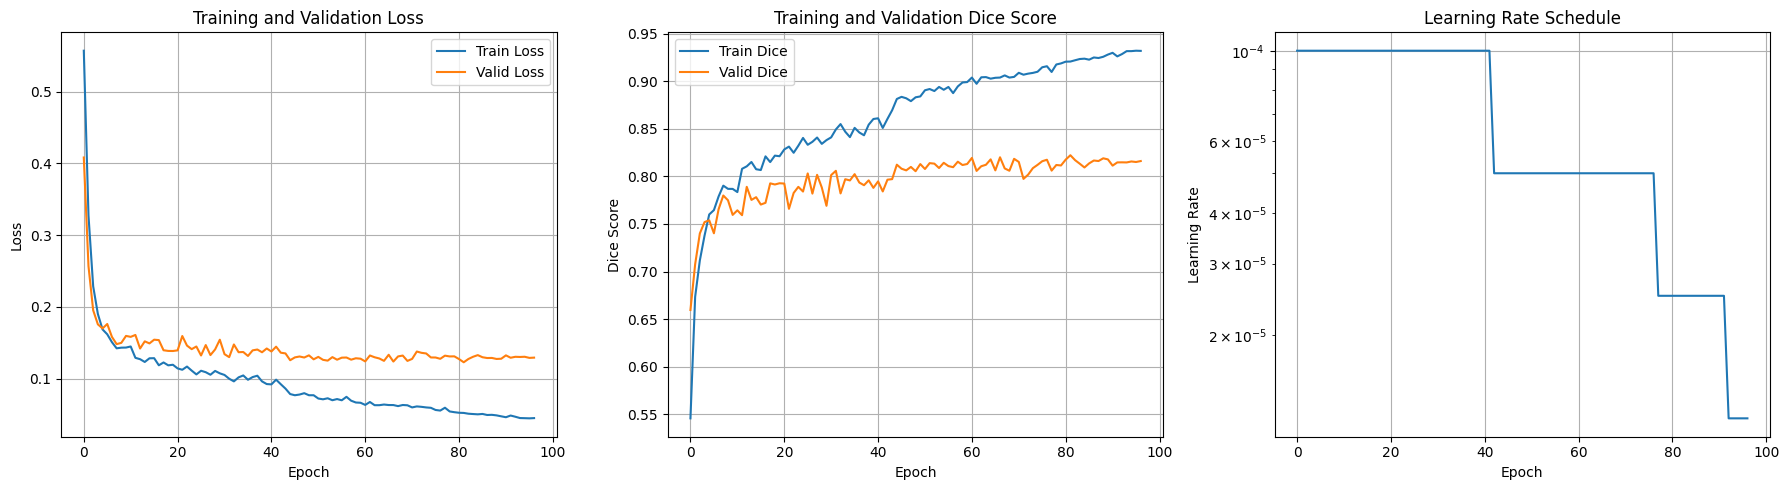

In [25]:
# =============================================================================
# 繪製訓練曲線
# =============================================================================

# 儲存訓練歷史
with open('results/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# 繪製訓練曲線
plot_training_history(history, save_path='results/training_curves.png')

In [26]:
# =============================================================================
# 在測試集上評估
# =============================================================================

print('\n' + '='*50)
print('在測試集上評估...')
print('='*50)

# 載入最佳模型
checkpoint = torch.load('models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# 測試
avg_metrics, all_metrics = test_model(model, test_loader, device, save_dir='./results')

print('\n測試集平均指標:')
print('-' * 30)
for key, value in avg_metrics.items():
    print(f'{key.capitalize():12s}: {value:.4f}')

# 儲存測試結果
with open('results/test_metrics.json', 'w') as f:
    json.dump({
        'average': avg_metrics,
        'all_samples': all_metrics
    }, f, indent=2)


在測試集上評估...


C:\Users\Kslab\AppData\Local\Temp\ipykernel_4952\948788619.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/best_model.pth')
Testing: 100


測試集平均指標:
------------------------------
Dice        : 0.7993
Iou         : 0.6995
Precision   : 0.8242
Recall      : 0.8264
F1          : 0.7993



產生預測視覺化...


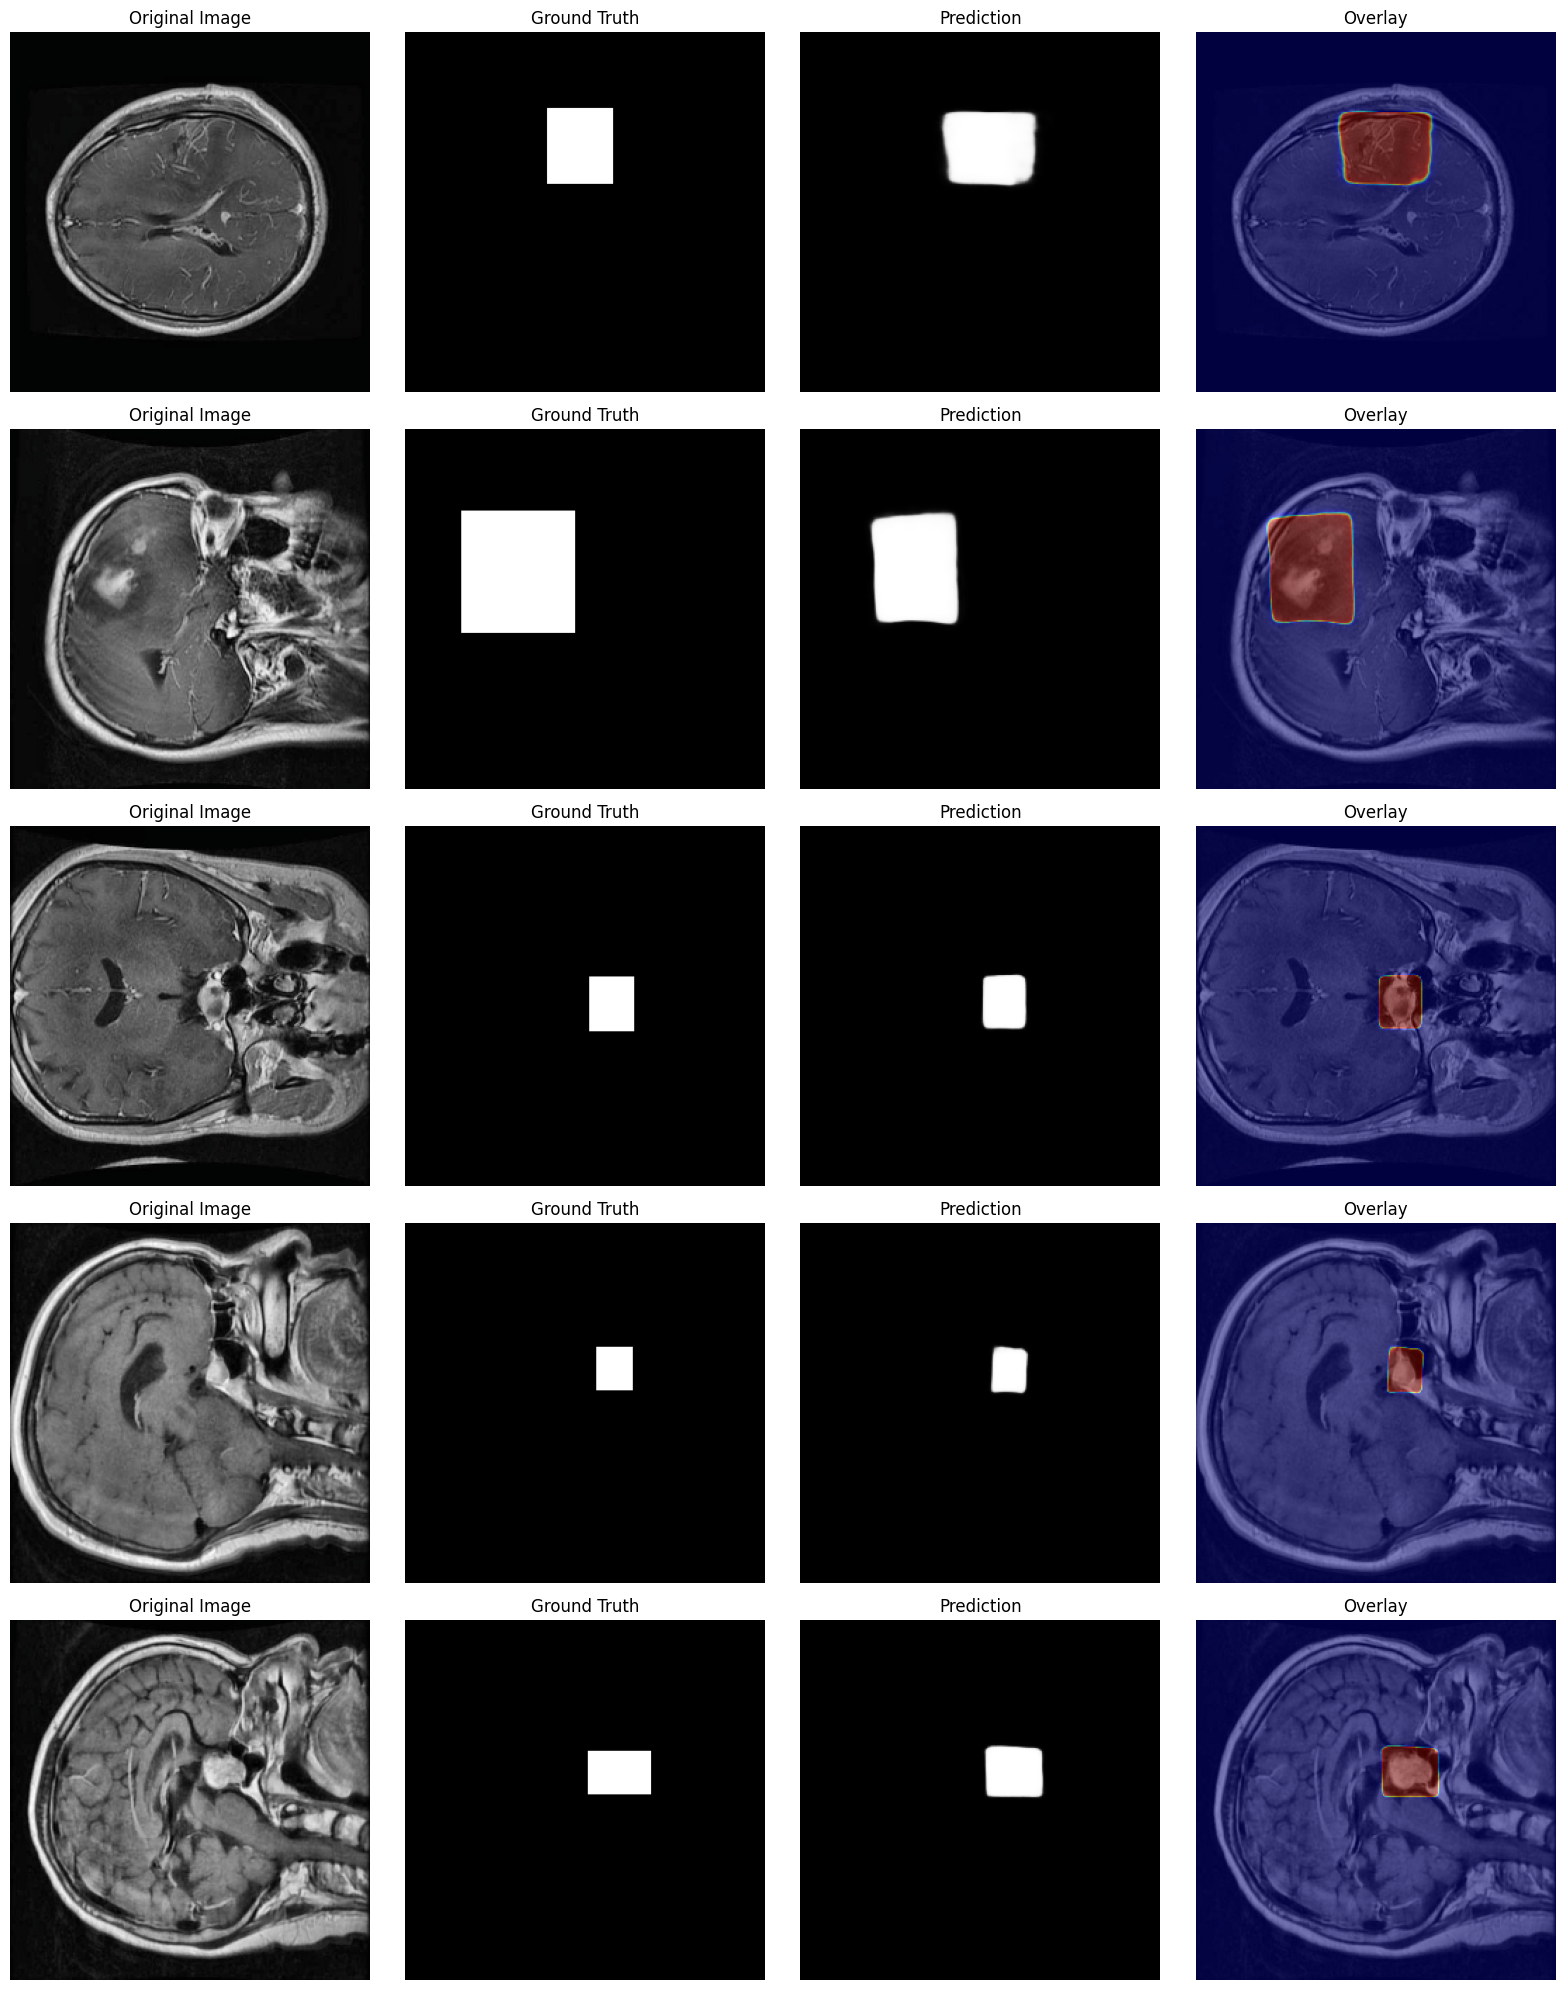


✓ 所有結果已儲存至 results/ 目錄


In [27]:
# =============================================================================
# 視覺化預測結果
# =============================================================================

print('\n' + '='*50)
print('產生預測視覺化...')
print('='*50)

test_dataset = BrainTumorDataset(
    TEST_DIR, 
    TEST_ANN,
    transform=ValidTransform()
)

visualize_predictions(
    model, 
    test_dataset, 
    device, 
    num_samples=5,
    save_path='results/predictions.png'
)

print('\n✓ 所有結果已儲存至 results/ 目錄')

## 10. 疑難排解 & 常見問題

### CUDA Timeout 錯誤

如果遇到 `CUDA error: the launch timed out and was terminated`:
- 降低 `BATCH_SIZE` (目前已是最小值 1)
- 減小 `image_size` (在 Transform 中調整，例如改為 512 或 448)
- 訓練時關閉其他應用程式

### DataLoader Worker 崩潰

Windows 系統常見問題：
- 確認 `NUM_WORKERS = 0`（目前已設定）

### OpenMP 錯誤

如果看到 `OMP: Error #15`:
- 確認已執行 `os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'`（notebook 開頭已設定）

### 記憶體不足

如果 GPU 顯存不足：
```python
# 降低批次大小（已經是 1，無法再降低）
# 降低影像解析度
TrainTransform(image_size=512)  # 或 448
```

### 訓練太慢

使用 GTX 960 4GB 確實會很慢，建議：
1. 降低影像解析度到 512 或 448
2. 使用雲端 GPU (Google Colab, Kaggle)
3. 讓訓練在夜間連續運行

### 檢查 GPU 使用

開新的終端執行：
```bash
nvidia-smi -l 1
```

確認：
- GPU 使用率接近 100%
- 顯存使用 < 4GB
- 溫度在 70-85°C 範圍

---

## 結語

這個 notebook 包含了完整的腦腫瘤分割專案程式碼，所有功能都已整合並優化。

**主要特色：**
- ✅ 完整的 U-Net 實作
- ✅ 所有問題修正（形狀、類型、Windows 相容性）
- ✅ GTX 960 優化設定
- ✅ 豐富的視覺化功能
- ✅ 詳細的說明文字

**祝訓練順利！** 🚀

In [ ]:
# '''
# Complete Training Loop with all integrated techniques:
# - SMP UNet++ with ResNet34 encoder
# - Mixed Precision Training (AMP)
# - AdamW optimizer + ReduceLROnPlateau scheduler
# - Combined Loss (BCE + Dice)
# '''

# # === Hyperparameters ===
# IMG_SIZE = 256
# BATCH_SIZE = 16  # Suitable for GTX 960 4GB
# EPOCHS = 50
# LR = 1e-4
# NUM_WORKERS = 4

# # === Training functions ===

# def train_one_epoch(model, loader, optimizer, scaler, device):
#     '''Train one epoch (with AMP acceleration)'''
#     model.train()
#     total_loss = 0.0
    
#     loop = tqdm(loader, desc='Training')
#     for images, masks in loop:
#         images = images.to(device)
#         masks = masks.to(device).unsqueeze(1).float()
        
#         optimizer.zero_grad()
        
#         # Mixed Precision Forward Pass
#         with autocast(device_type='cuda'):
#             logits = model(images)
#             loss = combined_loss(logits, masks)
        
#         # Mixed Precision Backward Pass
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        
#         total_loss += loss.item() * images.size(0)
#         loop.set_postfix(loss=loss.item())
    
#     return total_loss / len(loader.dataset)


# def validate(model, loader, device):
#     '''Validation function'''
#     model.eval()
#     total_loss = 0.0
#     total_iou = 0.0
#     total_dice = 0.0
    
#     with torch.no_grad():
#         loop = tqdm(loader, desc='Validating')
#         for images, masks in loop:
#             images = images.to(device)
#             masks = masks.to(device).unsqueeze(1).float()
            
#             logits = model(images)
#             loss = combined_loss(logits, masks)
            
#             total_loss += loss.item() * images.size(0)
#             total_iou += iou_score(logits, masks).item() * images.size(0)
#             total_dice += dice_score(logits, masks).item() * images.size(0)
    
#     n = len(loader.dataset)
#     return total_loss/n, total_iou/n, total_dice/n


# def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
#     '''Calculate IoU (Intersection over Union)'''
#     pred = (torch.sigmoid(pred) > threshold).float()
#     inter = (pred * target).sum()
#     union = pred.sum() + target.sum() - inter
#     return (inter + epsilon) / (union + epsilon)


# def dice_score(pred, target, threshold=0.5, epsilon=1e-7):
#     '''Calculate Dice Score'''
#     pred = (torch.sigmoid(pred) > threshold).float()
#     inter = (pred * target).sum()
#     return (2 * inter + epsilon) / (pred.sum() + target.sum() + epsilon)


# # === Build DataLoaders ===
# train_dir = r'./train'
# valid_dir = r'./valid'
# test_dir = r'./test'

# train_ann = r'./train/_annotations.coco.json'
# valid_ann = r'./valid/_annotations.coco.json'
# test_ann = r'./test/_annotations.coco.json'

# train_loader, valid_loader, test_loader = create_dataloaders(
#     train_dir, valid_dir, test_dir,
#     train_ann, valid_ann, test_ann,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS
# )

# print(f'[OK] Train set: {len(train_loader.dataset)} images')
# print(f'[OK] Valid set: {len(valid_loader.dataset)} images')
# print(f'[OK] Test set: {len(test_loader.dataset)} images')

# # === Build model ===
# model = create_model()
# model = model.to(device)

# # === Optimizer and Scheduler ===
# optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# # GradScaler for Mixed Precision Training
# scaler = GradScaler()

# # === Training history ===
# history = {
#     'train_loss': [],
#     'val_loss': [],
#     'val_iou': [],
#     'val_dice': []
# }

# best_dice = 0.0
# best_iou = 0.0

# print('\n' + '='*60)
# print(' START TRAINING')
# print('='*60)

# # Clean memory
# gc.collect()
# torch.cuda.empty_cache()

# # === Training Loop ===
# for epoch in range(EPOCHS):
#     print(f'\nEpoch {epoch+1}/{EPOCHS}')
#     print('-' * 60)
    
#     # Train
#     train_loss = train_one_epoch(model, train_loader, optimizer, scaler, device)
    
#     # Validate
#     val_loss, val_iou, val_dice = validate(model, valid_loader, device)
    
#     # Update scheduler
#     scheduler.step(val_dice)
    
#     # Record
#     history['train_loss'].append(train_loss)
#     history['val_loss'].append(val_loss)
#     history['val_iou'].append(val_iou)
#     history['val_dice'].append(val_dice)
    
#     # Print results
#     print(f'Train Loss: {train_loss:.4f}')
#     print(f'Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f}')
#     print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
#     # Save best model
#     if val_dice > best_dice:
#         best_dice = val_dice
#         best_iou = val_iou
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'best_dice': best_dice,
#             'best_iou': best_iou,
#         }, 'best_model_smp.pth')
#         print(f'[SAVED] Best model (Dice: {best_dice:.4f})')
    
#     # Memory cleanup
#     if (epoch + 1) % 5 == 0:
#         gc.collect()
#         torch.cuda.empty_cache()

# print('\n' + '='*60)
# print(' TRAINING COMPLETE!')
# print(f' Best Dice Score: {best_dice:.4f}')
# print(f' Best IoU: {best_iou:.4f}')
# print('='*60)


[OK] Train set: 1502 images
[OK] Valid set: 429 images
[OK] Test set: 215 images


C:\Users\Kslab\AppData\Local\Temp\ipykernel_4952\4234943107.py:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



 START TRAINING

Epoch 1/50
------------------------------------------------------------


Training:   0%|          | 0/94 [00:00<?, ?it/s]